<a href="https://colab.research.google.com/github/sinux-l5d/PROJ002/blob/main/animal_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
# Options for this notebook
DO = {
    "UNZIP": False, # unzip ./animal-10.zip to ./animal-10
    "ZIP": False, # zip ./logs and best.keras to model_and_logs.zip
    "TRAIN": True # train the model (if False, load the existing model from best.keras)
}

In [123]:
from dataclasses import dataclass
from pathlib import Path
from os import listdir
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import os
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [124]:
DATADIR = "animal10"
WIDTH = 200
HEIGHT = 200

In [125]:
if DO.get("UNZIP", False):
    data_zip = "animal-10.zip"
    with zipfile.ZipFile(data_zip,"r") as zip_ref:
        zip_ref.extractall(DATADIR)

In [126]:
#run on graphic card if possible
gpus = tf.config.list_physical_devices('GPU')
print("nb gpus", len(gpus))
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

nb gpus 1
1 Physical GPUs, 1 Logical GPU


In [127]:
translate = {'cane': 'dog', 'cavallo': 'horse', 'elefante': 'elephant', 'farfalla': 'butterfly', 'gallina': 'chicken', 'gatto': 'cat', 'mucca': 'cow', 'pecora': 'sheep', 'scoiattolo': 'squirrel', 'dog': 'cane', 'elephant': 'elefante', 'butterfly': 'farfalla', 'chicken': 'gallina', 'cat': 'gatto', 'cow': 'mucca', 'spider': 'ragno', 'squirrel': 'scoiattolo', 'horse': 'cavallo', 'ragno': 'spider', 'sheep': 'pecora'}
CATEGORIES = [translate[name] for name in listdir(DATADIR + "/raw-img")]
CATEGORIES.sort()
print(list(enumerate(CATEGORIES)))

[(0, 'butterfly'), (1, 'cat'), (2, 'chicken'), (3, 'cow'), (4, 'dog'), (5, 'elephant'), (6, 'horse'), (7, 'sheep'), (8, 'spider'), (9, 'squirrel')]


In [128]:
@dataclass
class Collection:
  path = Path(DATADIR + "/raw-img")
  train_perct = 0.8

  def getCategory(self, category: str) -> pd.Series:
    dirsp = translate.get(category, None)
    if dirsp == None:
      raise Exception("Invalid category")
    imgs = list(self.path.glob(dirsp + "/*"))
    filenames = pd.Series(imgs, name="Filepath").astype(str)
    labels = pd.Series([category for _ in range(len(imgs))], name="Label")
    return pd.concat([filenames, labels], axis=1)

  def computeMaxs(self, maxreq):
    lenghts = {k: len(self.getCategory(k)) for k in CATEGORIES}
    total = sum(lenghts.values())
    return {k: round((v/total)*maxreq) for k, v in lenghts.items()}
  
  def lenCategories(self) -> dict[int]:
    return {k: len(self.getCategory(k)) for k in CATEGORIES}

  def getTrain(self, maxs={}):
      out = []
      for category in CATEGORIES:
          df = self.getCategory(category)
          end = maxs.get(category, len(df))
          end = round(end * self.train_perct)
          out.append(df[:end])
      return pd.concat(out)

  def getTest(self, maxs={}):
      out = []
      for category in CATEGORIES:
          df = self.getCategory(category)
          end = maxs.get(category, len(df))
          start = round(end * self.train_perct)
          out.append(df[start:end])
      return pd.concat(out)


In [129]:
def display_row(*imgs):
    _, ax = plt.subplots(1, len(imgs), figsize=(20, 20))
    if not isinstance(ax, np.ndarray):
        ax = np.array([ax])
    for i, img in enumerate(imgs):
        ax[i].imshow(img)
        ax[i].axis('off')

In [130]:
c = Collection()
nbPicPerCat = c.lenCategories()
minkey = min(nbPicPerCat, key=lambda x: nbPicPerCat[x])
maximums = {k: nbPicPerCat[minkey] for k in nbPicPerCat}
print(maximums)

{'butterfly': 1446, 'cat': 1446, 'chicken': 1446, 'cow': 1446, 'dog': 1446, 'elephant': 1446, 'horse': 1446, 'sheep': 1446, 'spider': 1446, 'squirrel': 1446}


In [131]:
from keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(rescale = 1./255,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   horizontal_flip=True,
                                   rotation_range=10,
                                #    zoom_range=0.2,
                                   brightness_range=(0.5, 1.3))
datagen_test = ImageDataGenerator(rescale=1./255)

In [132]:
def getGenerator(idg, df, batch_size=32):
    return idg.flow_from_dataframe(
        dataframe=df,
        x_col="Filepath",
        y_col="Label",
        target_size=(WIDTH, HEIGHT),
        batch_size=batch_size,
        shuffle=True,
        class_mode="categorical"
    )

In [133]:
set_train = getGenerator(datagen_train, c.getTrain(maximums).sample(frac=1)) # yes, rudendent shuffle
set_test = getGenerator(datagen_test, c.getTest(maximums), 1)

Found 11570 validated image filenames belonging to 10 classes.


Found 2890 validated image filenames belonging to 10 classes.


In [134]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 198, 198, 256)     7168      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 99, 99, 256)      0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 99, 99, 256)      1024      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 99, 99, 256)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 97, 97, 128)       295040    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 48, 48, 128)     

In [135]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [136]:
if DO.get("TRAIN", False):
    
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint("e{epoch:02d}-a{val_accuracy:.3f}.keras", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max"),
        tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_images=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
    ]
    set_test.reset()
    model.fit(set_train,
            validation_data = set_test,
            validation_steps = len(set_test),
            epochs=30,
            callbacks=callbacks,
            batch_size=32)


In [137]:
model.load_weights("best.keras")
test_loss, test_acc = model.evaluate(set_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

2890/2890 [==============================] - 15s 5ms/step - loss: 1.3890 - accuracy: 0.5571
Test accuracy: 0.5570934414863586
Test loss: 1.3890328407287598


In [138]:
if DO.get("ZIP", False):
  import os
  with zipfile.ZipFile('model_and_logs.zip', 'w') as z:
      for root, dirs, files in os.walk('logs/'):
        for file in files:
          z.write(os.path.join(root, file),
                  os.path.relpath(os.path.join(root, file),
                  os.path.join('logs/', '..')))

      # Ajout du fichier "best.keras" à l'archive
      z.write("best.keras", os.path.basename("best.keras"))


In [139]:
# https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
def predict(model, imgFromSet):
  pred = model.predict(imgFromSet, verbose=0)
  return CATEGORIES[np.argmax(pred)]


On this sample : 21/50 (42.0%)


<Figure size 1000x500 with 0 Axes>

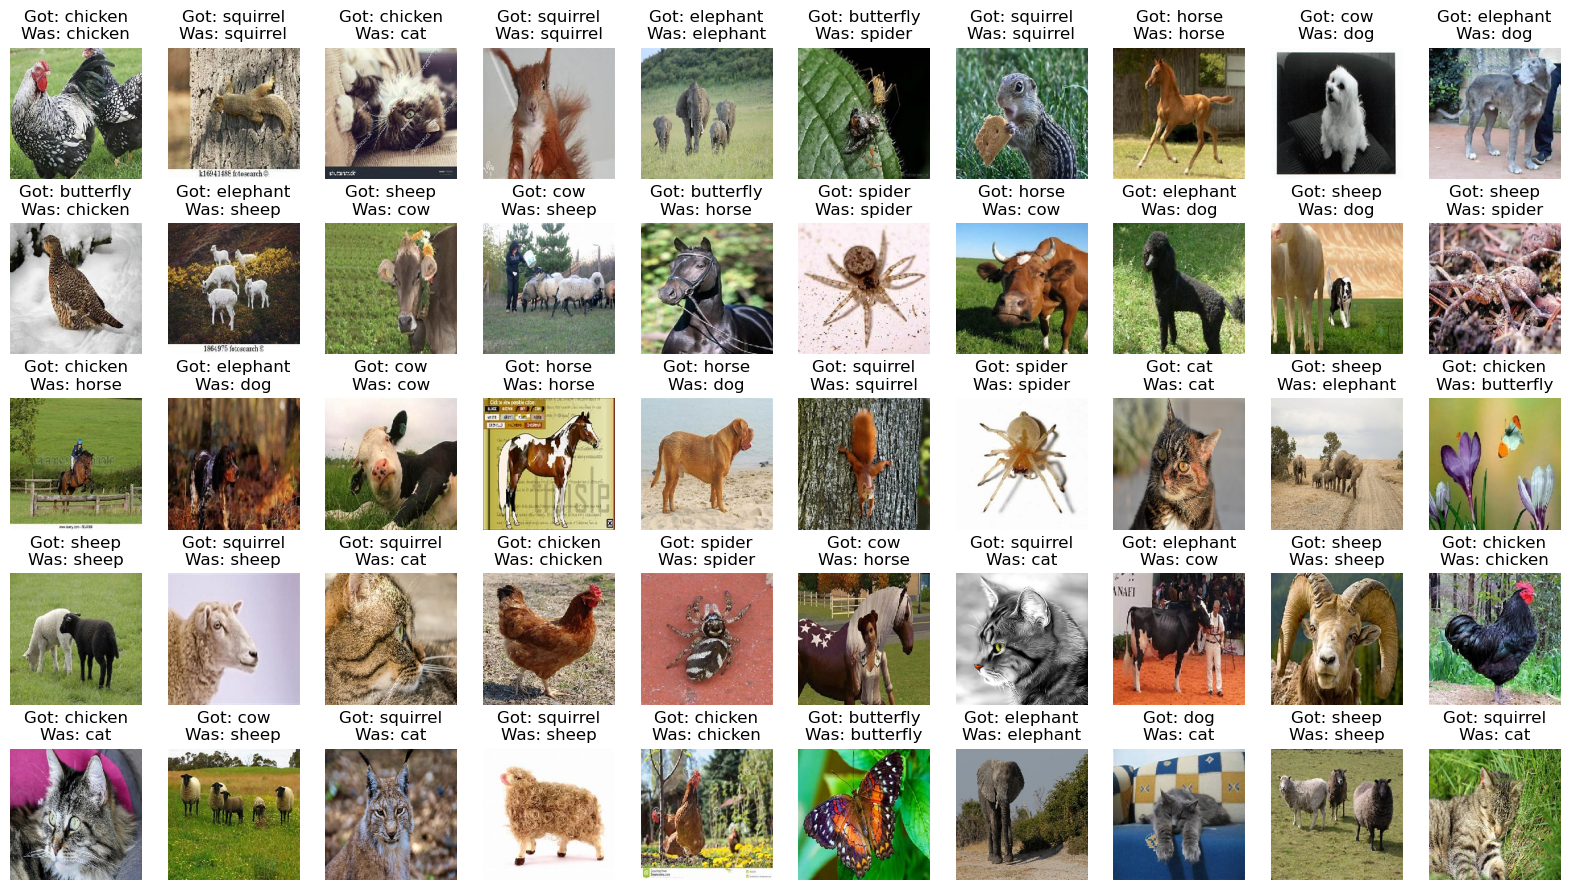

In [140]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
set_test.reset()
right = 0
MAX = 50
width = min(MAX, 10)
height = (MAX + width - 1) // width
plt.subplots(height, width, figsize=(width * 2, height * 2+1))
for i in range(MAX):
  img, label = set_test.next()
  plt.subplot(height, width, i+1)
  plt.imshow(img[0])
  got = predict(model, img)
  was = CATEGORIES[np.argmax(label[0])]
  plt.title("Got: " + got + "\nWas: " + was)
  plt.axis('off')
  right += got == was
print(f"On this sample : {right}/{MAX} ({str(100*right/MAX)}%)")
plt.show()

In [141]:
confusion_matrix = np.zeros((10,10), dtype = int)

for i in range(len(set_test)):
  img, label = set_test.next()
  got = predict(model, img)
  was = CATEGORIES[np.argmax(label[0])]
  confusion_matrix[CATEGORIES.index(was)][CATEGORIES.index(got)] += 1


KeyboardInterrupt: 

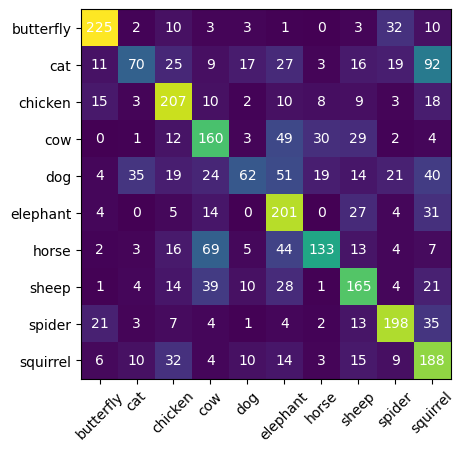

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(confusion_matrix)

# Add numbers to each square
for i in range(len(CATEGORIES)):
    for j in range(len(CATEGORIES)):
        text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color="w")
# axis labels as categories name

plt.xticks(range(len(CATEGORIES)), CATEGORIES, rotation=45)
plt.yticks(range(len(CATEGORIES)), CATEGORIES)
plt.show()


In [ ]:
# Correctness rate from confusion matrix
m = max(CATEGORIES, key=len)
for i, c in enumerate(CATEGORIES):
    nbspace = " "*(len(m)-len(c))
    print(f"{c} {nbspace}: {confusion_matrix[i,i]/sum(confusion_matrix[i]):.2%}")

butterfly : 77.85%
cat       : 24.22%
chicken   : 72.63%
cow       : 55.17%
dog       : 21.45%
elephant  : 70.28%
horse     : 44.93%
sheep     : 57.49%
spider    : 68.75%
squirrel  : 64.60%


<Figure size 1000x500 with 0 Axes>

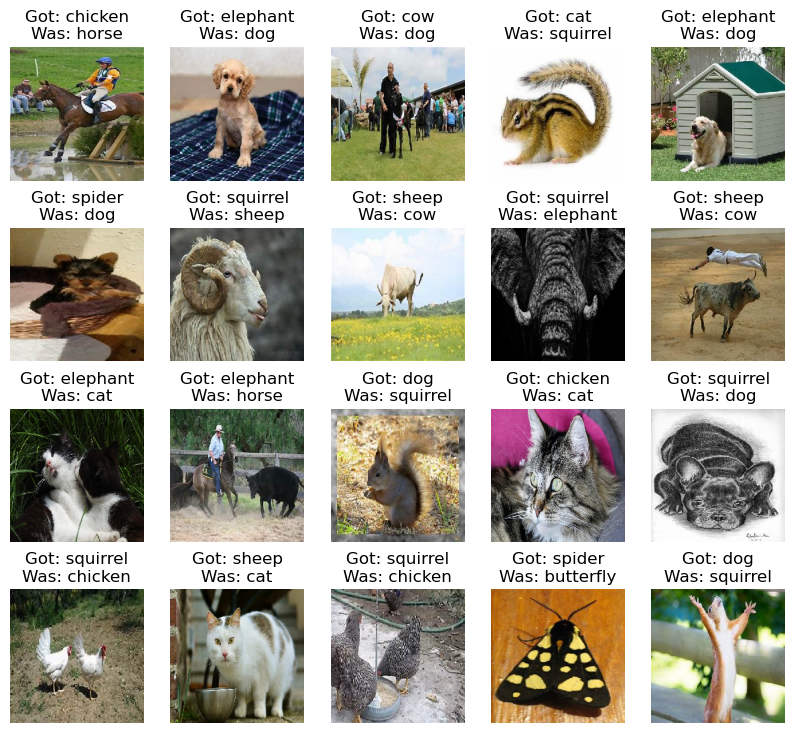

In [ ]:
# Sample of uncorrectly classified images

plt.figure(figsize=(10, 5))
set_test.reset()
count = 0
MAX = 20
width = min(MAX, 5)
height = (MAX + width - 1) // width
plt.subplots(height, width, figsize=(width * 2, height * 2+1))
while count < MAX:
  img, label = set_test.next()
  got = predict(model, img)
  was = CATEGORIES[np.argmax(label[0])]
  if got != was:
    count += 1
    plt.subplot(height, width, count)
    plt.imshow(img[0])
    plt.title("Got: " + got + "\nWas: " + was)
    plt.axis('off')